# Deep learning volatility

In [1]:
%config Completer.use_jedi=False
# import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import csv
import pandas as pd
import scipy


In [2]:
import os
os.chdir('Data')
# os.getcwd()
print(scipy.__version__)

1.7.0


In [81]:
import gzip
f= gzip.GzipFile("impliedVols_total.txt.gz","r")
df = np.load(f)
xx = df[:, :15]
yy = df[:, 15:]
len(df), len(df[0])

(200535, 87)

In [82]:
np.round(df[:3, 15:],2)

array([[0.6 , 0.57, 0.55, 0.53, 0.53, 0.55, 0.58, 0.61, 0.65, 0.69, 0.73,
        0.77, 0.34, 0.33, 0.32, 0.31, 0.31, 0.32, 0.34, 0.35, 0.37, 0.4 ,
        0.42, 0.44, 0.28, 0.27, 0.26, 0.26, 0.25, 0.25, 0.26, 0.26, 0.27,
        0.29, 0.3 , 0.31, 0.26, 0.26, 0.25, 0.24, 0.24, 0.24, 0.24, 0.24,
        0.25, 0.25, 0.27, 0.28, 0.26, 0.25, 0.24, 0.24, 0.23, 0.23, 0.23,
        0.23, 0.23, 0.24, 0.24, 0.25, 0.25, 0.24, 0.24, 0.23, 0.23, 0.22,
        0.22, 0.22, 0.22, 0.22, 0.23, 0.23],
       [1.05, 1.  , 0.96, 0.91, 0.86, 0.82, 0.77, 0.72, 0.68, 0.63, 0.6 ,
        0.59, 0.69, 0.66, 0.63, 0.6 , 0.58, 0.55, 0.52, 0.49, 0.47, 0.44,
        0.42, 0.4 , 0.53, 0.51, 0.49, 0.48, 0.46, 0.44, 0.42, 0.4 , 0.39,
        0.37, 0.35, 0.34, 0.48, 0.47, 0.45, 0.44, 0.42, 0.41, 0.39, 0.38,
        0.36, 0.35, 0.34, 0.32, 0.45, 0.44, 0.43, 0.41, 0.4 , 0.39, 0.37,
        0.36, 0.35, 0.34, 0.32, 0.31, 0.44, 0.42, 0.41, 0.4 , 0.39, 0.38,
        0.36, 0.35, 0.34, 0.33, 0.32, 0.31],
       [0.51, 0.47, 0.

In [83]:
S0 = 1.
r = 0.
logmoneyness = np.array([-0.15, -0.12, -0.09, -0.06, -0.03, 0.0, 0.03, 0.06, 0.09, 0.12, 0.15, 0.18])
strikes=np.exp(S0*logmoneyness)
maturities=np.array([0.05,0.15,0.3,0.4,0.5,0.6])

strikes_dim = len(strikes)
maturities_dim = len(maturities)
strikes_dim, maturities_dim

(12, 6)

In [84]:
#remove invalid paramters
invalid = np.where(yy == yy.min())[0]
xx = np.delete(xx, (invalid), axis=0)[:200000]
yy = np.delete(yy, (invalid), axis=0)[:200000]
print(xx.shape, yy.shape)
for i in range(15):
    print(np.min(xx[:, i]),np.max(xx[:, i]))

(200000, 15) (200000, 72)
0.5 2.5
1.0 1.5
0.1 0.6
0.01 0.5
0.0001 0.03
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5
-0.5 0.5


### Model Parameters Scaling: $\theta\to scale(\theta)\in[0,1]$
$$scale(\theta^i)=\frac{2\theta^i-(\theta^i_{min}+\theta^i_{max})}{\theta^i_{max}-\theta^i_{min}},\quad i \in |\Theta|$$

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, y_test = train_test_split(
    xx, yy, test_size=10000, random_state=42)
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scale = StandardScaler()
# y_train_transform = scale.fit_transform(y_train)
# y_test_transform = scale.transform(y_test)
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, test_size=20000, random_state=42)

$\alpha\in[0.505, 0.7],\; \lambda\in[0.5, 1.5],\; a\in[0.1, 0.75],\; b\in[0.05, 0.5],\; c\in[0.0001, 0.01],\; Z_0\in[0.05, 0.3]$

In [86]:
ub=np.max(xx, axis=0)
lb=np.min(xx, axis=0)
print(lb, ub)
def myscale(x):
    res=np.zeros(len(xx[0]))
    for i in range(len(xx[0])):
        res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res=np.zeros(len(xx[0]))
    for i in range(len(xx[0])):
        res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
    return res

[ 5.e-01  1.e+00  1.e-01  1.e-02  1.e-04 -5.e-01 -5.e-01 -5.e-01 -5.e-01
 -5.e-01 -5.e-01 -5.e-01 -5.e-01 -5.e-01 -5.e-01] [2.5  1.5  0.6  0.5  0.03 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5 ]


In [87]:
x_train_transform = np.array([myscale(x) for x in x_train])
x_test_transform = np.array([myscale(x) for x in X_test])
x_val_transform = np.array([myscale(x) for x in x_val])

x_train_transform.shape, x_test_transform.shape,x_val_transform.shape
# np.max(x_train_transform, axis=0)

((170000, 15), (10000, 15), (20000, 15))

# Step 2. Create the Neural Network

In [89]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')

input1 = keras.layers.Input(shape=(len(xx[0]),))
x1 = keras.layers.Dense(32,activation = 'elu')(input1)
x2=keras.layers.Dense(32,activation = 'elu')(x1) 
x3=keras.layers.Dense(32,activation = 'elu')(x2) 
x4=keras.layers.Dense(32,activation = 'elu')(x3) 
x5=keras.layers.Dense(32,activation = 'elu')(x4) 
# x5=keras.layers.Dense(strikes_dim*maturities_dim,activation = 'linear')(x4)
x6=keras.layers.Dense(strikes_dim*maturities_dim,activation = 'linear')(x5)

modelGEN = keras.models.Model(inputs=input1, outputs=x6)
modelGEN.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_45 (Dense)             (None, 32)                512       
_________________________________________________________________
dense_46 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_47 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_48 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_49 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_50 (Dense)             (None, 72)              

# Step 3. Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [92]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
optim = keras.optimizers.Adam(learning_rate = 0.005)
modelGEN.compile(loss = root_mean_squared_error, optimizer = optim)

In [93]:
from keras.callbacks import LearningRateScheduler, EarlyStopping
patience = 10
NumEpochs=500
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          mode="min",
                          verbose=1, 
                          patience=patience)
def decay_schedule(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr *= 0.5
    return lr 
        
lr_scheduler = LearningRateScheduler(decay_schedule)
modelGEN.fit(x_train_transform, y_train, 
             batch_size=128,
#              validation_split = 0.2,
             validation_data = (x_val_transform, y_val),
             epochs = 200, verbose = True,shuffle=1, callbacks=[earlystop, lr_scheduler])             

Epoch 1/200
1329/1329 [==============================] - 3s 2ms/step - loss: 0.0905 - val_loss: 0.0883
Epoch 2/200
1329/1329 [==============================] - 3s 2ms/step - loss: 0.0895 - val_loss: 0.0894
Epoch 3/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0889 - val_loss: 0.0879
Epoch 4/200
1329/1329 [==============================] - 3s 2ms/step - loss: 0.0886 - val_loss: 0.0875
Epoch 5/200
1329/1329 [==============================] - 3s 2ms/step - loss: 0.0884 - val_loss: 0.0899
Epoch 6/200
1329/1329 [==============================] - 3s 2ms/step - loss: 0.0882 - val_loss: 0.0862
Epoch 7/200
1329/1329 [==============================] - 3s 2ms/step - loss: 0.0883 - val_loss: 0.0859
Epoch 8/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0882 - val_loss: 0.0887
Epoch 9/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0883 - val_loss: 0.0856
Epoch 10/200
1329/1329 [==============================] - 3s 2ms/step - l

Epoch 80/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0849 - val_loss: 0.0834
Epoch 81/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0851 - val_loss: 0.0834
Epoch 82/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0849 - val_loss: 0.0834
Epoch 83/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0846 - val_loss: 0.0834
Epoch 84/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0849 - val_loss: 0.0834
Epoch 85/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0848 - val_loss: 0.0834
Epoch 86/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0851 - val_loss: 0.0834
Epoch 87/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0850 - val_loss: 0.0834
Epoch 88/200
1329/1329 [==============================] - 2s 2ms/step - loss: 0.0848 - val_loss: 0.0834
Epoch 89/200
1329/1329 [==============================] - 2s 2ms

### Store/Load optimal NN parameteres

In [94]:
modelGEN.save_weights('qrHestonNNWeights.h5')

In [95]:
modelGEN.load_weights('qrHestonNNWeights.h5')

In [115]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())
# np.savetxt("nnParameters.txt", np.asarray(NNParameters))
# NNParameters

# Step 4. Optimisation
### (Numpy Implementation of the Neural Network tends to be faster than Keras)

Here the *elu* function writes:
$$elu(x) = \begin{cases}e^{x}-1,\; x<0\\
x,\; x\geq 0.
\end{cases}$$

In [140]:
NumLayers=5
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(15)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
#     grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    grad=np.dot(grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

# Compute Implied vol relative errors on Test set

In [117]:
### Compute the 95% confidence interval for a given 2d array(column data as variable) and the filtered array
def filter_CI95(arr, li = 0.025, ui = 0.975):
    res = []
    lq = np.quantile(arr, li, axis=0)
    uq = np.quantile(arr, ui, axis=0)
    for i in range(len(arr[0])):
        sub = arr[:, i]
        tmp = sub[np.logical_and(sub>=lq[i], sub<=uq[i])]
        res.append(tmp)
#         print(len(tmp))
    return res 

In [118]:
prediction[0].shape

()

<ipython-input-119-53eba4ec639a>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(maturities)


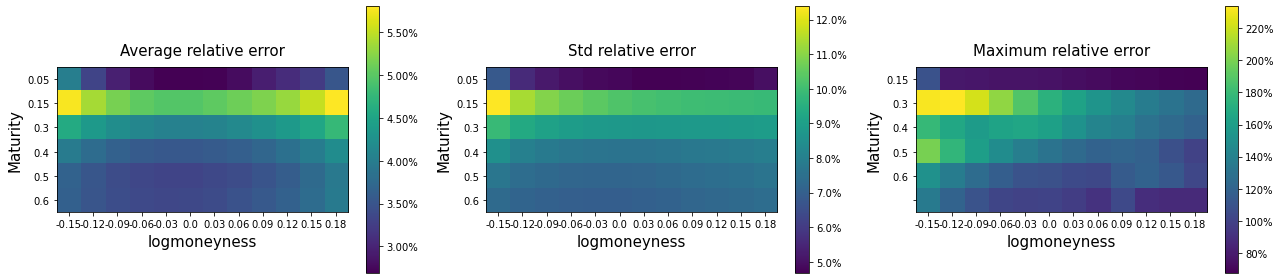

In [119]:
##### AVERAGE VALUES #######
%matplotlib inline
X_sample = x_test_transform
y_sample = y_test
# prediction=[modelGEN.predict(X_sample[i].reshape(1,6))[0] for i in range(len(X_sample))]
prediction=[NeuralNetwork(X_sample[i]) for i in range(len(X_sample))]
# err_relative = np.abs((y_sample-prediction)/y_sample)
# err_CI95 = filter_CI95(err_relative)

RMSE = np.sqrt(np.mean(np.power(y_sample-prediction, 2), axis=1)) ### compute the RMSE of the calibrated smile surface

plt.figure(1,figsize=(18,4))
ax=plt.subplot(1,3,1)
# err = np.array([100*np.mean(e) for e in err_CI95]) 
err = np.mean(100*np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(np.round(strikes,2))
ax.set_xticklabels(logmoneyness)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("logmoneyness",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
# err = np.array([100*np.std(e) for e in err_CI95]) 
err = 100*np.std(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(strikes)
ax.set_xticklabels(logmoneyness)

ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("logmoneyness",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
# err = np.array([100*np.max(e) for e in err_CI95]) 
err = 100*np.max(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
# ax.set_xticklabels(strikes)
ax.set_xticklabels(logmoneyness)
ax.set_yticklabels(maturities)
plt.xlabel("logmoneyness",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
# plt.savefig('qrHestonNNErrors.png', dpi=300)
plt.show()


# Plot sample Smiles

[ 1.27  1.16  0.49  0.38  0.    0.05 -0.21  0.43  0.    0.48  0.4  -0.07
 -0.37 -0.26  0.19]


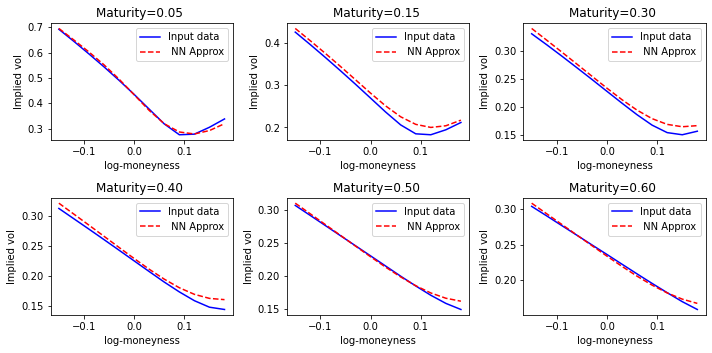

[ 1.83  1.31  0.34  0.21  0.02  0.49 -0.23 -0.24 -0.5   0.39  0.17 -0.3
  0.38  0.1  -0.2 ]


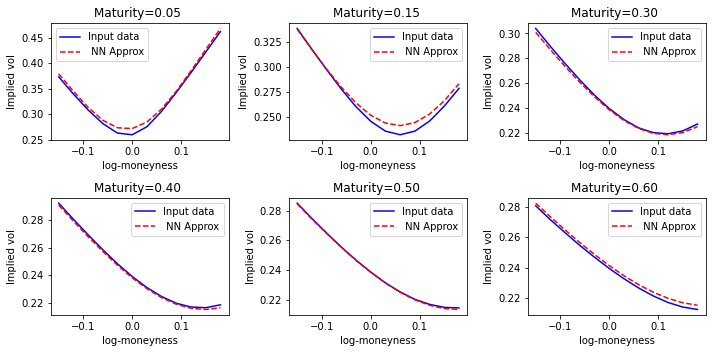

[ 2.11  1.17  0.13  0.44  0.01 -0.01 -0.11 -0.43  0.45 -0.02 -0.22 -0.36
 -0.07 -0.12  0.28]


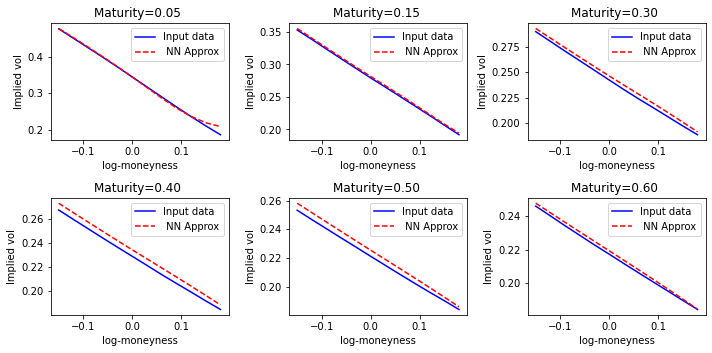

[ 0.95  1.08  0.27  0.31  0.02  0.39  0.33  0.46 -0.23 -0.34  0.28 -0.08
  0.25  0.32  0.38]


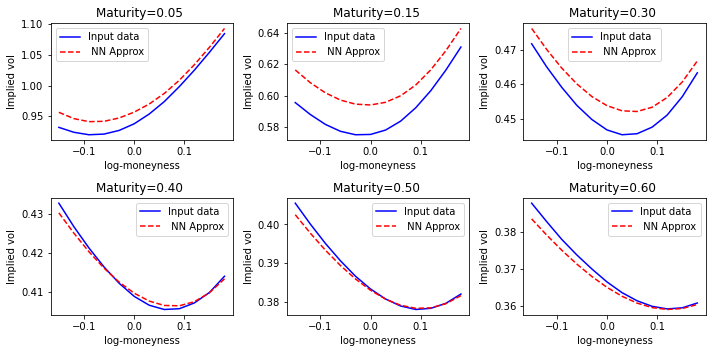

[ 0.86  1.25  0.41  0.14  0.01  0.1  -0.02 -0.3  -0.39 -0.29 -0.08  0.05
 -0.39  0.48 -0.24]


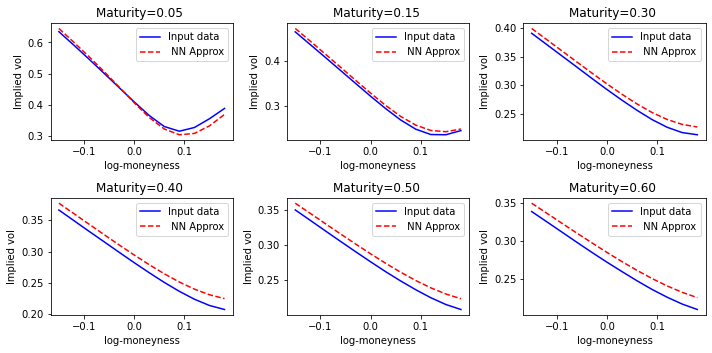

[ 0.66  1.11  0.46  0.11  0.    0.16  0.23  0.34 -0.04 -0.38  0.19  0.14
 -0.18  0.5  -0.09]


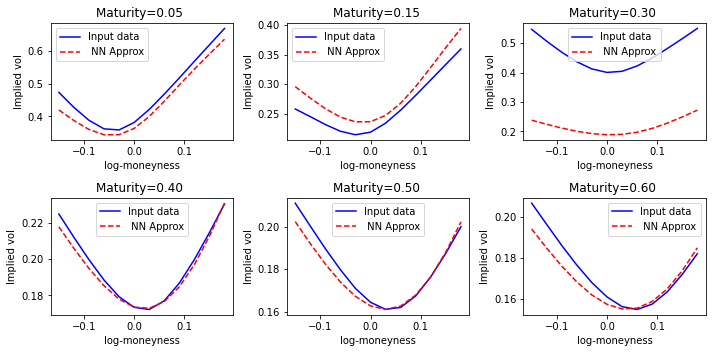

[ 0.74  1.03  0.33  0.21  0.01  0.1   0.29  0.48  0.11 -0.22  0.39  0.41
 -0.37 -0.01  0.33]


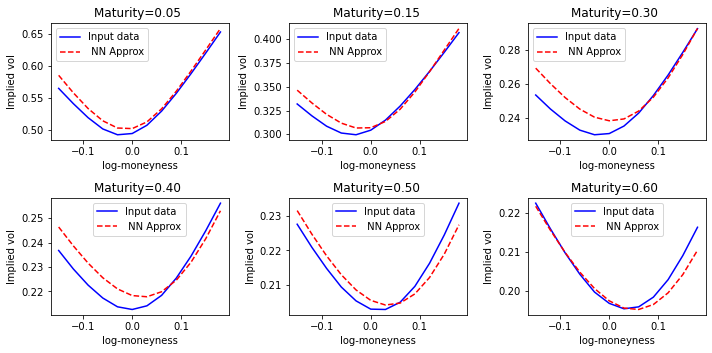

[ 2.29  1.04  0.17  0.37  0.02 -0.45 -0.44 -0.19 -0.35  0.44 -0.11 -0.31
 -0.42 -0.03 -0.49]


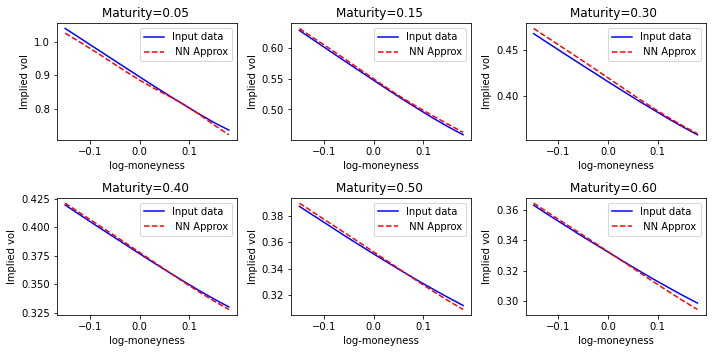

[ 1.4   1.01  0.14  0.19  0.02 -0.47 -0.08  0.27  0.07 -0.47  0.16  0.31
  0.22  0.5   0.46]


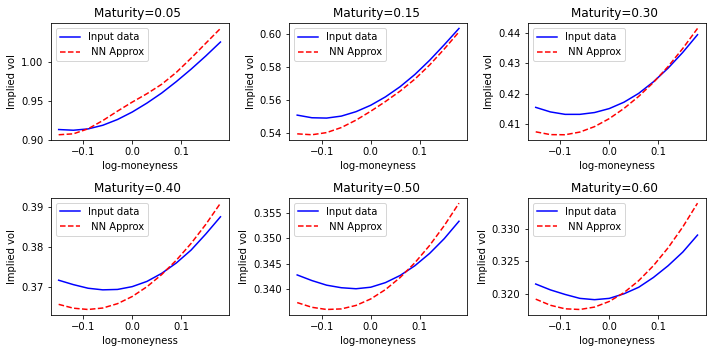

[ 1.44  1.49  0.2   0.23  0.03 -0.23 -0.3  -0.44  0.3   0.37  0.   -0.02
 -0.47 -0.2  -0.4 ]


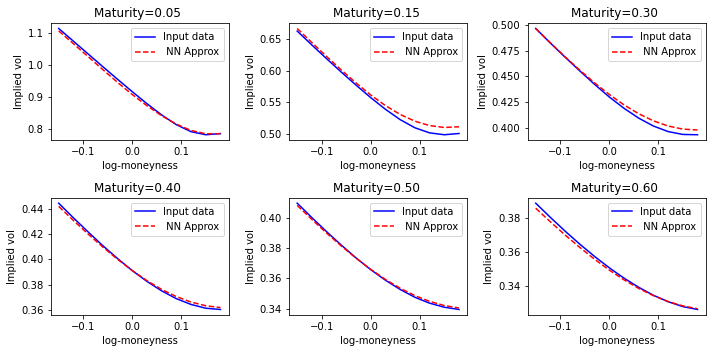

In [120]:
import time
for j in range(10):
    sample_ind = j 
    X_sample = x_test_transform[sample_ind]
    y_sample = y_test[sample_ind]
    print(np.round(X_test[sample_ind],2))
    prediction=NeuralNetwork(X_sample)
#     prediction=scale.inverse_transform(modelGEN.predict(X_sample.reshape(1,6))[0])
    plt.figure(1,figsize=(10,7))
    for i in range(maturities_dim):
        plt.subplot(3,3,i+1)

        plt.plot(logmoneyness, y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
        plt.plot(logmoneyness, prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")


        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
#     time.sleep(5)
    

In [136]:
%matplotlib qt 
# %matplotlib inline
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1,projection = '3d')
X, Y = np.meshgrid(logmoneyness, maturities)
rng = np.random.default_rng()
i = rng.integers(len(x_test_transform))
print("Test sample id: ",i)
Z = NeuralNetwork(x_test_transform[i]).reshape(maturities_dim, -1)
Z_real = y_test[i].reshape(maturities_dim,-1)-0.2
surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm, linewidth=0, antialiased=False, label="smile prediction")
surf_real = ax.plot_surface(X, Y, Z_real, cmap = cm.coolwarm, linewidth=0, antialiased=False, label="smile(shifted downside by 0.2)")

ax.set_xlabel("logmoneyness")
ax.set_ylabel("maturities")
ax.set_zlim(-.25, .8)
ax.zaxis.set_major_formatter("{x:.02f}")
fig.colorbar(surf, shrink=0.25, aspect=5)
plt.title("volatility smile for test sample %d"%i)
# plt.legend()
plt.show()

Test sample id:  1780


# Use gradient methods for optimisation

In [137]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-y_test[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-y_test[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-y_test[sample_ind])

def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [157]:
import time

Approx=[]
Timing = []

solutions=np.zeros((3, 15))
init=np.zeros(15)
for i in range(len(X_test)):
    disp=str(i+1)+"/" + str(len(X_test))
    print (disp, end="\r")
    times = np.zeros(3)
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end = time.time()
    solutions[0,:]=myinverse(I.x)
    times[0] = end-start
#     I=scipy.optimize.least_squares(CostFuncLS, init, JacobianLS,method='lm',args=(i,),gtol=1E-10)
    I=scipy.optimize.least_squares(CostFuncLS, init, JacobianLS,bounds=([-1]*15, [1]*15),args=(i,),gtol=1E-10)
    
#     init = I.x 
    end= time.time()
    solutions[1,:]=myinverse(I.x)
    times[1]=end-start
    
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS, init, JacobianLS, method='lm',args=(i,),gtol=1E-10)
    end= time.time()
    solutions[2,:]=myinverse(I.x)
    times[2]=end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing), 15))
# print("solution: ", np.round(np.mean(Approx, axis=0), 6))

time spent: 7275.644750118256s


In [167]:
Approx1=[]
Timing = []

for i in range(len(X_test)):
    disp=str(i+1)+"/" + str(len(X_test))
    print (disp, end="\r")
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end = time.time()
    solutions[0,:]=myinverse(I.x)
    times = end-start
    
    Approx1.append(np.copy(solutions[0,:]))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing), 15))

time spent: 2864.185229063034s


# Save the Lavenberg-Marquardt Optimal parameters

In [168]:
LMParameters=np.array([Approx1[i] for i in range(len(Approx))])
np.savetxt("NNParametersQuadraticRoughHeston.txt",LMParameters)
LMParameters = np.loadtxt("NNParametersQuadraticRoughHeston.txt")
LMParameters.shape
init_lm = np.mean(LMParameters, axis=0)
# Approx[0][0], Approx[0][1]
init_lm

array([ 2.41573734,  0.69128191,  0.31918008,  0.34094898, -0.02975118,
       -1.10373498, -1.61098373,  1.30207951,  0.07875625,  0.83646703,
       -1.22157774,  1.21288845, -0.7435301 ,  0.75117814, -0.48000414])

In [169]:

RMSE = np.sqrt(np.mean(np.power(LMParameters-X_test, 2), axis=1)) ### compute the RMSE of the calibrated smile surface

# Calibration Errors with Levenberg-Marquardt

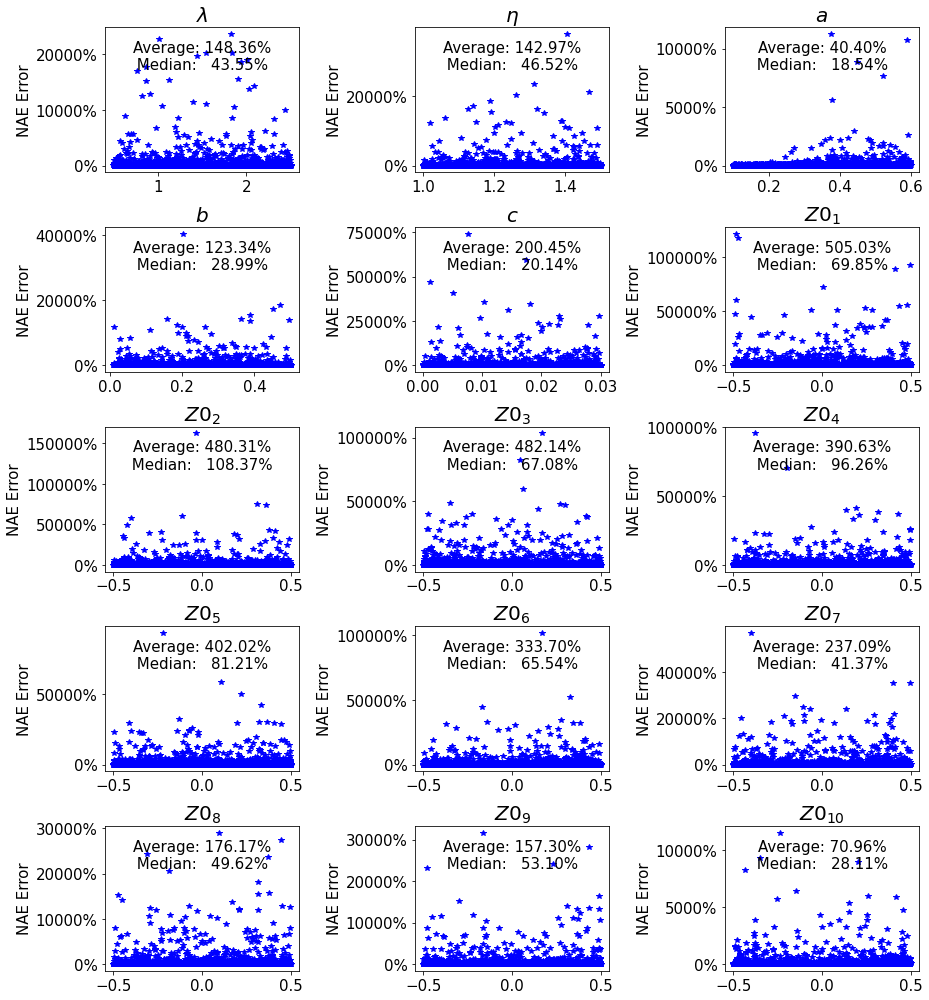

In [170]:
%matplotlib inline
titles=["$\\lambda$","$\\eta$","$a$","$b$", "$c$"]
for i in range(1, 11):
    s = "$Z0_{"+str(i)+"}$"
    titles.append(s)
average_nae=np.zeros([15, len(X_test)])
fig=plt.figure(figsize=(13,14))
for u in range(15):
    ax=plt.subplot(5,3,u+1)
    x=X_test[:,u]
#     print(abs(LMParameters[:1800,u]))
#     print(100*np.abs(LMParameters[:1800,u]))
    lu = ub[u]-lb[u]
    average_nae[u,:]=np.abs(LMParameters[:,u]-x)/lu
    plt.plot(x,100*average_nae[u,:],'b*')
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('NAE Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(100*np.mean(average_nae[u,:]),100*np.quantile(average_nae[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

plt.savefig('qrHestonParameterNAEErrors.png', dpi=300)
plt.show()

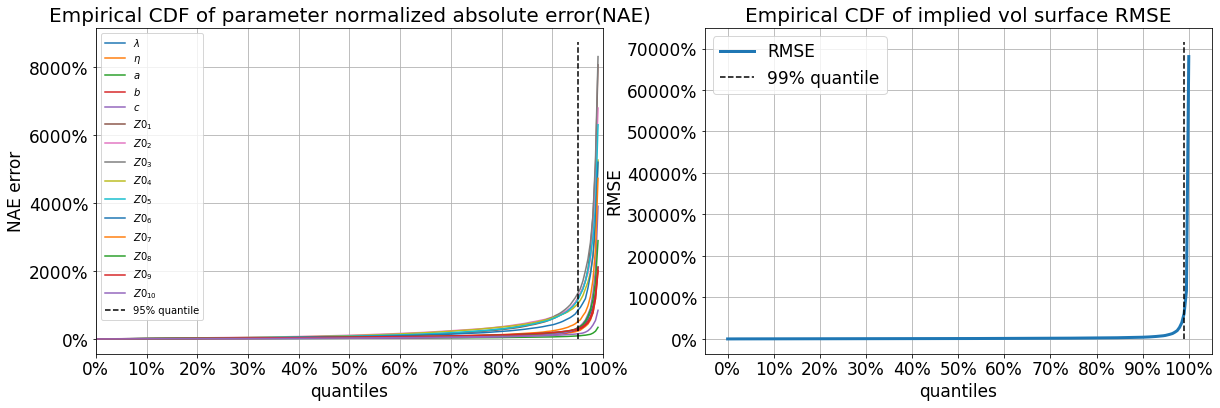

In [171]:
plt.figure(figsize=(20, 6))
plt.clf()
plt.subplot(121)
ax = plt.gca()
q=np.linspace(0,0.99,200)
for u in range(15):
    p=plt.plot(100*q,np.quantile(100*average_nae[u,:],q),label=titles[u])
    c=p[0].get_color()
    ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(100*np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")
plt.title("Empirical CDF of parameter normalized absolute error(NAE)",fontsize=20)
plt.legend(fontsize=10, loc=2)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("NAE error",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()

plt.subplot(122)
ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(100*q,np.quantile(100*RMSE,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(100*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('qrHestonErrorCDF.png', dpi=300)
plt.show()


## Calibration on market data

In [172]:
from scipy import  interpolate
from scipy.interpolate import griddata
import json

df_logmoneyness_market = json.load(open('logmoneyness_market.json'))
df_market = json.load(open('impliedVols_market.json'))
### maturities and strikes on the market
maturities_market = [0.06, 0.15, 0.31, 0.56]
print("Market logmoneyness: ",df_logmoneyness_market[10])
print("Model logmoneyness: ",np.round(logmoneyness,3))
print("Model Maturities: " ,maturities)
# df_market

Market logmoneyness:  [-0.118, -0.097, -0.077, -0.056, -0.008, 0.039, 0.083, 0.126, 0.167]
Model logmoneyness:  [-0.15 -0.12 -0.09 -0.06 -0.03  0.    0.03  0.06  0.09  0.12  0.15  0.18]
Model Maturities:  [0.05 0.15 0.3  0.4  0.5  0.6 ]


In [173]:
def interpolation_NN(x, maturities_market, logmoneyness_market):
    """
    a function for the interpolation of the market data to the NeuralNetwork
    Input: 
        x: the input sample for the Neural Network function
        logmonyness_market(dim=9), maturities_market(dim=4)
    Output: 
        f: the interpolation results of the NeuralNetwork, 
        df: the interpolation results of the NeuralNetworkGradient
    """
    
    sbs = interpolate.RectBivariateSpline(maturities, logmoneyness, NeuralNetwork(x).reshape(maturities_dim,-1))
    fnew = sbs(maturities_market, logmoneyness_market) 
#     X,Y = np.meshgrid(logmoneyness, maturities)
#     sbs = interpolate.SmoothBivariateSpline(X.ravel(), Y.ravel(), NeuralNetwork(x))
#     return sbs(logmoneyness_market, maturities_market).ravel()
     
    return fnew.ravel()

def interpolation_NN_Gradient(x, maturities_market, logmoneyness_market):
    """
    a function for the interpolation of the market data to the NeuralNetworkGradient
    Input: 
        x: the input sample for the Neural Network function
        logmonyness_market(dim=9), maturities_market(dim=4)
    Output: 
        gradient: the interpolation results of the NeuralNetworkGradient
    """
    gradient    = np.zeros((6, len(logmoneyness_market)*len(maturities_market)))
    nnGradient  = NeuralNetworkGradient(x)
    
    for i in range(6):
        sbs = interpolate.RectBivariateSpline(maturities, logmoneyness, nnGradient[i].reshape(maturities_dim,-1))
        gradient[i] = sbs(maturities_market, logmoneyness_market).ravel()

    return gradient
    


In [174]:
def CostFunc_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    interpolated = interpolation_NN(x,maturities_market, logmoneyness_market)
    return np.sum(np.power(interpolated - df_market[sample_ind], 2))

def Jacobian_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    interpolated = interpolation_NN(x,maturities_market, logmoneyness_market)
    gradient = interpolation_NN_Gradient(x,maturities_market, logmoneyness_market)
    
    return 2*np.sum((interpolated - df_market[sample_ind])*gradient,axis=1)

# #Cost Function for Levenberg Marquardt

def CostFuncLS_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    interpolated = interpolation_NN(x,maturities_market, logmoneyness_market)
    return (interpolated - df_market[sample_ind])

def JacobianLS_(x,sample_ind):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    return interpolation_NN_Gradient(x,maturities_market, logmoneyness_market).T

In [175]:
def CostFunc_c(c, sample_ind, init_x):
    x1 = init_x.copy()
    x1[-2] = c 
    interpolated = interpolation_NN(x1, maturities_market, df_logmoneyness_market[sample_ind])
    return np.sum(np.power(interpolated - df_market[sample_ind], 2))

In [176]:
from scipy.optimize import  Bounds, LinearConstraint
bounds = Bounds([-1.]*15, [1.]*15)
l = np.array([1., np.inf, np.inf, np.inf, np.inf, np.inf])
constraints = LinearConstraint(np.diag(np.ones(15)), -np.ones(15), np.ones(15))

# constraints = LinearConstraint(np.diag(np.ones(6)), -np.ones(6), np.ones(6))

bounds = [(-1., 1.)]*15


In [177]:
import time 
Approx=[]
Timing = []

solutions=np.zeros([4,15])
# init = myscale(np.array([0.51, 1.2, 0.384, 0.095, 0.0025, 0.1]))
init = np.zeros(15)
times = np.zeros(4)
for i in range(len(df_market)):
    disp=str(i+1)+"/" + str(len(df_market))
    print (disp, end="\r")
#     args=(i,)
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='Powell', tol=1E-10,
                              bounds = bounds,
                              options={"maxiter": 5000})
    end= time.time()
    solutions[1, :]=myinverse(I.x)
    times[1] = end-start
    
    
    # Cobyla - gradient free method "
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='COBYLA', tol=1E-10,
                              constraints = constraints,
                              options={"maxiter": 5000})
    end= time.time()
    solutions[2, :]=myinverse(I.x)
    times[2] = end-start
    
    ## Nelder-Mead Method
    start= time.time()
    I=scipy.optimize.minimize(CostFunc_, x0=init, args=(i,), method='Nelder-Mead', tol=1E-10,
                              bounds = bounds,
                              options={"maxiter": 5000, "adaptive":True})
    end= time.time()
    solutions[3, :]=myinverse(I.x)
    times[3] = end-start
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing, axis=0), 6))

time spent: [   0.       1188.053934  181.746222  285.625937]s


In [198]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
for i in range(2):
    print(Approx[i][3], Approx[i][2])


[ 1.74082  1.02830  0.54471  0.01041  0.02570  0.23959  0.45853 -0.48841
  0.49680 -0.17538  0.49311 -0.49854 -0.10924  0.45393 -0.21867] [ 2.41047  1.25259  0.28679  0.12395  0.02968  0.38186  0.30940  0.34245
  0.40456  0.50000  0.16635 -0.22066 -0.07320 -0.02584 -0.06547]
[ 2.13686  1.08981  0.56057  0.09762  0.02074  0.49753 -0.40521 -0.48135
  0.49380  0.49842  0.48514 -0.49864 -0.22749  0.49255 -0.21157] [ 2.50000  1.27095  0.29296  0.08622  0.03000  0.49262  0.42104  0.36084
  0.50000  0.49998 -0.01492 -0.10244 -0.05597 -0.17647  0.19173]


In [184]:
### results with bounds
for j in range(1,4):
    tmp = [Approx[i][j] for i in range(len(Approx))]
    print("Mean:",np.mean(tmp, axis=0))
    print("Std: ",np.round(np.std(tmp, axis=0), 10))
    print("-------------------------------------------------------------------------------")
    

Mean: [ 1.28393  1.27643  0.30417  0.10743  0.02364 -0.01679 -0.11751  0.38965
  0.43448  0.36074  0.05860 -0.24255 -0.17349  0.20682 -0.10173]
Std:  [ 0.57326  0.14433  0.06746  0.06671  0.00401  0.44152  0.41564  0.24828
  0.18856  0.19619  0.22011  0.15850  0.12489  0.15396  0.11667]
-------------------------------------------------------------------------------
Mean: [ 2.28928  1.37312  0.33912  0.02989  0.02169  0.39170  0.39208  0.24218
  0.17032  0.12012  0.05201 -0.12455 -0.11142 -0.07779  0.07069]
Std:  [ 0.23788  0.11735  0.04161  0.02970  0.00521  0.14935  0.13821  0.21251
  0.23776  0.17443  0.10907  0.14791  0.10354  0.13438  0.09701]
-------------------------------------------------------------------------------
Mean: [ 2.08250  1.37863  0.35724  0.02419  0.02009 -0.18641 -0.27984 -0.11965
  0.32532  0.32579  0.19371 -0.38738 -0.11300  0.19552 -0.10718]
Std:  [ 0.46906  0.15078  0.09924  0.02007  0.00511  0.33324  0.28024  0.34497
  0.25758  0.22665  0.23104  0.18211  0.1

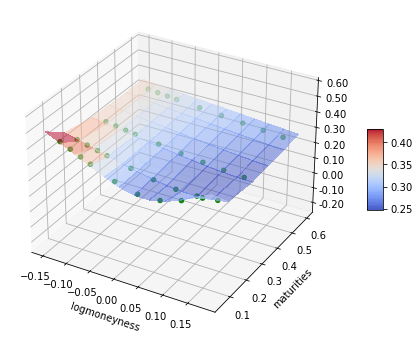

In [225]:
### Interpolation figure
%matplotlib qt 

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection = '3d')
# init = np.zeros(15)
init = Approx[0][2]

X, Y = np.meshgrid(logmoneyness, maturities)
Z = NeuralNetwork(init).reshape(maturities_dim, -1)

logmoneyness_market = df_logmoneyness_market[0]
X1, Y1 = np.meshgrid(logmoneyness_market, maturities_market)
Z1 = interpolation_NN(init, maturities_market, logmoneyness_market).reshape(len(maturities_market), -1)


surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5)
points = ax.scatter(X1, Y1, Z1, c='g')

ax.set_xlabel("logmoneyness")
ax.set_ylabel("maturities")
ax.set_zlim(-.25, .6)
ax.zaxis.set_major_formatter("{x:.02f}")
fig.colorbar(surf, shrink=0.25, aspect=5)
plt.savefig("qrHeston_smile_market.png", dpi=300)
plt.show()

loss:  0.0026067788876492255
[ 2.41047  1.25259  0.28679  0.12395  0.02968  0.38186  0.30940  0.34245
  0.40456  0.50000  0.16635 -0.22066 -0.07320 -0.02584 -0.06547]


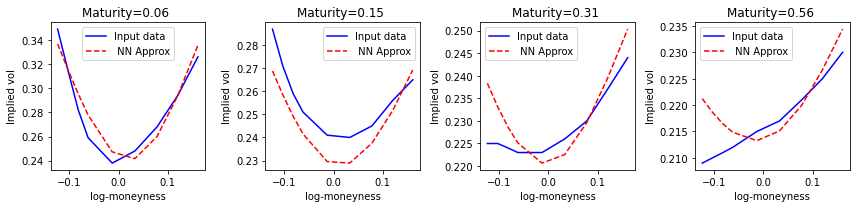

loss:  0.002545151917499122
[ 2.50000  1.27095  0.29296  0.08622  0.03000  0.49262  0.42104  0.36084
  0.50000  0.49998 -0.01492 -0.10244 -0.05597 -0.17647  0.19173]


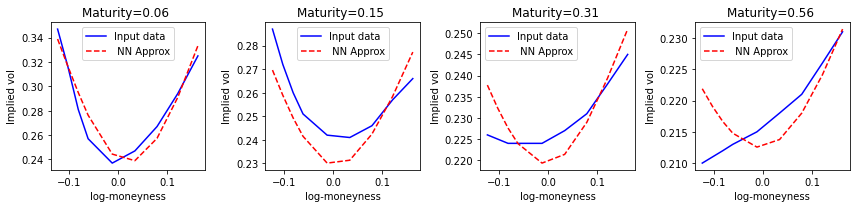

In [211]:
%matplotlib inline

for sample_ind  in range(2):
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    l = len(logmoneyness_market)
    
    X_sample = myscale(Approx[sample_ind][3])
    y_sample = df_market[sample_ind]
    prediction=interpolation_NN(X_sample, maturities_market, logmoneyness_market)
    print("loss: ",CostFunc_(X_sample, sample_ind))
    print(Approx[sample_ind][2])
    
    plt.figure(1,figsize=(12,3))
    for i in range(len(maturities_market)):
        plt.subplot(1,4,i+1)
 
        plt.plot(logmoneyness_market, y_sample[i*l :(i+1)*l],'b',label="Input data")
        plt.plot(logmoneyness_market, prediction[i*l :(i+1)*l],'--r',label=" NN Approx")


        plt.title("Maturity=%1.2f "%maturities_market[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    
    plt.tight_layout()
    plt.show()


In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
strikes_dim=11
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
def plot_func(sample_ind, alpha,Lambda,a,b,c, Z0):
    x0=myscale(np.array([alpha,Lambda,a,b,c, Z0]))
    Smiles=df_market[sample_ind]
    logmoneyness_market = df_logmoneyness_market[sample_ind]
    strikes_dim_market = len(df_logmoneyness_market[sample_ind])
    
    Smiles_interpolated = interpolation_NN(x0, maturities_market, df_logmoneyness_market[sample_ind])
    
    plt.figure(1,figsize=(13,3))
    
    for i in range(4):
        plt.subplot(1,4,i+1)

        y1 = Smiles[i*strikes_dim_market:(i+1)*strikes_dim_market]
        y2 = Smiles_interpolated[i*strikes_dim_market:(i+1)*strikes_dim_market]
        plt.plot(logmoneyness_market,y1, '*r',label="Real Market Smile")
        plt.plot(logmoneyness_market,y2, '*g',label=" NN Approx interpolation")
        
        y = np.concatenate((y1, y2))
        plt.ylim(np.min(y)-.05, np.max(y)+.1)
        plt.title("Maturity=%1.2f "%maturities_market[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show() 


interact(plot_func, sample_ind = widgets.IntSlider(value=0, 
                                               min=0,
                                               max=len(df_market),
                                               step=1),
         alpha = widgets.FloatSlider(value=0.6,
                                               min=0.505,
                                               max=0.8,
                                               step=0.02),
         Lambda = widgets.FloatSlider(value=1.2,
                                               min=0.8,
                                               max=1.5,
                                               step=0.02),
         a = widgets.FloatSlider(value=0.25,
                                               min=0.1,
                                               max=0.5,
                                               step=0.02),
         b = widgets.FloatSlider(value=0.1,
                                               min=0.01,
                                               max=0.5,
                                               step=0.02),
         c = widgets.FloatSlider(value=0.005,
                                               min=0.001,
                                               max=0.01,
                                               step=0.005),
         Z0 = widgets.FloatSlider(value=0.1,
                                               min=0.05,
                                               max=0.3,
                                               step=0.05))